In [ ]:
# default_exp utils.dataset

# Dataset Utils

> API details.

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
import copy
import os
import random

import torch
from torch.utils.data import DataLoader, Dataset, RandomSampler
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


import pytorch_lightning as pl
from tqdm import tqdm

import cv2
from PIL import Image
import albumentations as A

from isic.config import *
from isic.sampler import ImbalancedDatasetSampler

C:\Users\bomco\miniconda3\envs\devtorch\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Unsupported `ReduceOp` for distributed computing.
  warnings.warn(*args, **kwargs)


In [ ]:
import seaborn as sns
sns.set_style('dark')

In [ ]:
#export
class SkinLabels:
    lesion_type_dict = {
        'nv': 'Melanocytic nevi',
        'mel': 'Melanoma',
        'bkl': 'Benign keratosis-like lesions',
        'bcc': 'Basal cell carcinoma',
        'akiec': 'Actinic keratoses',
        'vasc': 'Vascular lesions',
        'df': 'Dermatofibroma'
    }
    
    lesion_type_dict_inversed = {
      'Melanocytic nevi': 'nv',
      'Melanoma': 'mel',
      'Benign keratosis-like lesions': 'bkl',
      'Basal cell carcinoma': 'bcc',
      'Actinic keratoses': 'akiec',
      'Vascular lesions': 'vasc',
      'Dermatofibroma': 'df'
    }

    lesion_type_vi_dict = {
        'nv': 'Nốt ruồi',
        'mel': 'Ung thư hắc tố',
        'bkl': 'Dày sừng lành tính',
        'bcc': 'Ung thư biểu mô tế bào đáy',
        'akiec': 'Dày sừng quang hóa',
        'vasc': 'Thương tổn mạch máu',
        'df': 'U xơ da'
    }

In [ ]:
#export
def from_label_idx_to_key(label_idx, labels):
    label_string = labels[label_idx]
    key = SkinLabels.lesion_type_dict_inversed[label_string]
    return key

In [ ]:
#export
def preprocess_df(df, valid_size=0.2, seed=AppConfig.SEED, image_label_only=False, img_path = PathConfig.IMAGE_PATH):

    df['age'].fillna((df['age'].mean()), inplace=True)
    
    df['path'] = img_path + '/' + df['image_id'] + '.jpg'
    df['label_fullstr'] = df['dx'].map(SkinLabels.lesion_type_dict.get)

    label_str = pd.Categorical(df['label_fullstr'])
    df['label_index'] = label_str.codes

    df_undup = df.groupby('lesion_id').count()
    df_undup = df_undup[df_undup['image_id'] == 1]
    df_undup.reset_index(inplace=True)

    _, valid = train_test_split(df_undup['lesion_id'], test_size=valid_size, 
                                random_state=seed, 
                                stratify=df_undup['label_index'])
    valid = set(valid)
    df['val'] = df['lesion_id'].apply(lambda x: 1 if str(x) in valid else 0)

    df_train = df[df['val'] == 0]
    df_valid = df[df['val'] == 1]

    dest_df_train = df_train.reset_index(drop=True)
    dest_df_valid = df_valid.reset_index(drop=True)
    if not image_label_only:
        return dest_df_train, dest_df_valid, list(label_str.categories)
    else:
        train_imgs = []
        val_imgs = []
        i = 0
        for df in (dest_df_train, dest_df_valid):
            for j, path in enumerate(df['path']):
                x = np.array(Image.open(path))
                y = torch.tensor(int(df['label_index'][j]))
                if i == 0:
                    train_imgs.append((x, y))
                else:
                    val_imgs.append((x, y))
            i += 1
        return train_imgs, val_imgs, list(label_str.categories)

In [ ]:
#export
def get_default_train_transform(image_size=224, no_norm=False):
    transforms_train = [
        A.Transpose(p=0.5),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Resize(400, 400),
        A.RandomResizedCrop(image_size, image_size)
    ]
    norm = A.Normalize()
    if no_norm:
        norm = A.Normalize(mean=0, std=1)
    transforms_train.append(norm)
    return A.Compose(transforms_train)

def get_advanced_train_transform(image_size=224, cut_out=True, no_norm=False):
    transforms_train = [
        A.Transpose(p=0.5),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightness(limit=0.2, p=0.75),
        A.RandomContrast(limit=0.2, p=0.75),
        A.OneOf([
            A.MotionBlur(blur_limit=5),
            A.MedianBlur(blur_limit=5),
            A.GaussianBlur(blur_limit=5),
            A.GaussNoise(var_limit=(5.0, 30.0)),
        ], p=0.7),

        A.OneOf([
            A.OpticalDistortion(distort_limit=1.0),
            A.GridDistortion(num_steps=5, distort_limit=1.),
            A.ElasticTransform(alpha=3),
        ], p=0.7),

        A.CLAHE(clip_limit=4.0, p=0.7),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
        A.Resize(image_size, image_size)
    ]
    if cut_out:
        transforms_train.append(A.Cutout(max_h_size=int(image_size * 0.375), max_w_size=int(image_size * 0.375), num_holes=1, p=0.7))
    norm = A.Normalize()
    if no_norm:
        norm = A.Normalize(mean=0, std=1)
    transforms_train.append(norm)
    return A.Compose(transforms_train)

def get_default_val_transform(image_size=224):
    return A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize()
    ])

In [ ]:
# export
def split_df_to_cat_num_df(df):
    text_fields = ['image_id', 'lesion_id', 'dx', 'dx_type', 'localization', 'path', 'label_fullstr', 'sex']
    text_df = df.loc[:, df.columns.isin(text_fields)].copy()
    numerical_df = df.drop(columns = text_fields)

    image_id_cat = pd.Categorical(df['image_id'])
    text_df['img_id'] = image_id_cat.codes
    numerical_df['img_id']=image_id_cat.codes
    y = numerical_df['label_index']
    numerical_df = numerical_df.drop(columns=['label_index'])
    
    return text_df, numerical_df, y

In [ ]:
#export
def undersampling_df(df):
    from imblearn.under_sampling import RandomUnderSampler
    rus = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rus.fit_resample(df.drop(columns=['label_index']), df['label_index'])
    X_resampled['label_index'] = y_resampled
    return X_resampled

In [ ]:
#export
def oversampling_df(df):
    from imblearn.over_sampling import RandomOverSampler
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_resample(df.drop(columns=['label_index']), df['label_index'])
    X_resampled['label_index'] = y_resampled
    return X_resampled

In [ ]:
#export
def oversampling_not_flat_df(df, data_aug_rate=None):
    if data_aug_rate is None:
        data_aug_rate = [15,10,5,50,0,5,40]
    for i in range(7):
        if data_aug_rate[i]:
            df=df.append([df.loc[df['label_index'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
    return df

In [ ]:
def autolabel(rects,ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.005*height,
                '%d' % int(height),
                ha='center', va='bottom')

In [ ]:
def plot_train_val_distribution(train_df, valid_df):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,10))
    fig.suptitle('Train/Val label distribution')
    train = train_df['dx'].value_counts()
    val = valid_df['dx'].value_counts()
    rect1 = ax1.bar(train.keys(), train.values)
    rect2 = ax2.bar(val.keys(), val.values)
    autolabel(rect1,ax1)
    autolabel(rect2,ax2)

In [ ]:
def train_val_distribution(df_func=None):
    df = pd.read_csv(PathConfig.CSV_PATH)
    train_df, valid_df, labels = preprocess_df(df, 0.2)
    if df_func is not None:
        train_df = df_func(train_df)
    plot_train_val_distribution(train_df, valid_df)

In [ ]:
#export
def hybridsampling_df(df, data_aug_rate=None):
    if data_aug_rate is None:
        data_aug_rate = [7, 7, 3, 15,-0.2, 4, 15]
    for i in range(7):
        if data_aug_rate[i]>0:
            df=df.append([df.loc[df['label_index'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
        elif data_aug_rate[i]<0:
            entries = df.loc[df['label_index'] == i,:].index.tolist()
            dropIndices = np.random.choice(entries, size = int(len(entries)*abs(data_aug_rate[i])))
            df = df.drop(dropIndices)
            entries = df.loc[df['label_index'] == i,:].index.tolist()
    return df

In [ ]:
labels

['Actinic keratoses',
 'Basal cell carcinoma',
 'Benign keratosis-like lesions',
 'Dermatofibroma',
 'Melanocytic nevi',
 'Melanoma',
 'Vascular lesions']

In [ ]:
train_df['label_fullstr'].value_counts()

Melanocytic nevi                 5829
Melanoma                         1061
Benign keratosis-like lesions    1012
Basal cell carcinoma              472
Actinic keratoses                 300
Vascular lesions                  128
Dermatofibroma                    110
Name: label_fullstr, dtype: int64

In [ ]:
# train_df = pd.read_csv('/Work/Workspace/ML/HAM10000/aug/train.csv')
# valid_df = pd.read_csv('/Work/Workspace/ML/HAM10000/aug/valid.csv')
# plot_train_val_distribution(train_df, valid_df)


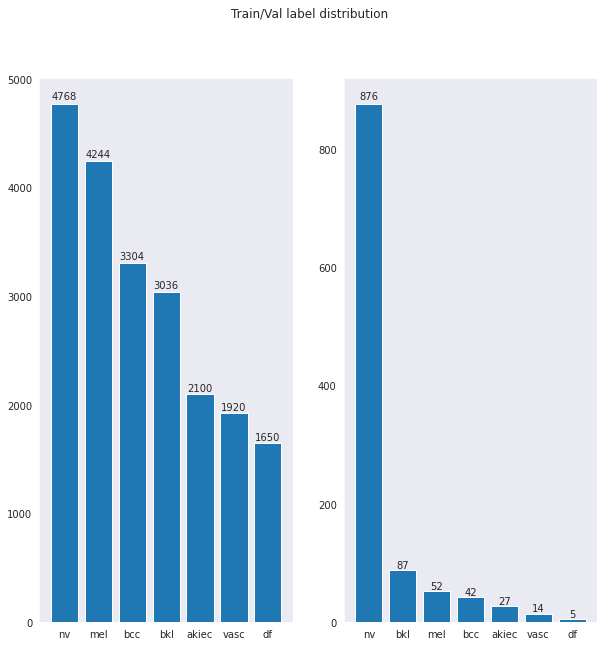

In [ ]:
train_val_distribution(hybridsampling_df)

In [ ]:
df = pd.read_csv(PathConfig.CSV_PATH)
train_df, valid_df, labels = preprocess_df(df, 0.2)
train_df = undersampling_df(train_df)
train_df['label_fullstr'].value_counts()

Dermatofibroma                   110
Vascular lesions                 110
Benign keratosis-like lesions    110
Actinic keratoses                110
Melanocytic nevi                 110
Melanoma                         110
Basal cell carcinoma             110
Name: label_fullstr, dtype: int64

In [ ]:
df = pd.read_csv(PathConfig.CSV_PATH)
train_df, valid_df, labels = preprocess_df(df, 0.2)
train_df = oversampling_df(train_df)
train_df['label_fullstr'].value_counts()

Dermatofibroma                   5829
Benign keratosis-like lesions    5829
Vascular lesions                 5829
Basal cell carcinoma             5829
Melanoma                         5829
Actinic keratoses                5829
Melanocytic nevi                 5829
Name: label_fullstr, dtype: int64

In [ ]:
[]

In [ ]:
df = pd.read_csv(PathConfig.CSV_PATH)
train_df, valid_df, labels = preprocess_df(df, 0.2)
train_df["label_index"].value_counts()

4    5829
5    1061
2    1012
1     472
0     300
6     128
3     110
Name: label_index, dtype: int64

In [ ]:
df = pd.read_csv(PathConfig.CSV_PATH)
train_df, valid_df, labels = preprocess_df(df, 0.2)
train_df = oversampling_not_flat_df(train_df)
train_df['label_fullstr'].value_counts()

Melanocytic nevi                 5829
Dermatofibroma                   5500
Melanoma                         5305
Vascular lesions                 5120
Benign keratosis-like lesions    5060
Basal cell carcinoma             4720
Actinic keratoses                4500
Name: label_fullstr, dtype: int64

In [ ]:
#export
class AdvancedHairAugmentation:
    """
    Impose an image of a hair to the target image

    Args:
        hairs (int): maximum number of hairs to impose
        hairs_folder (str): path to the folder with hairs images
    """

    def __init__(self, hairs: int = 5, hairs_folder: str = ""):
        self.hairs = hairs
        self.hairs_folder = hairs_folder

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        n_hairs = random.randint(0, self.hairs)
        
        if not n_hairs:
            return img
        
        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]
        
        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(hair_images)))
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            
            h_height, h_width, _ = hair.shape  # hair image width and height
            if img.shape[0] < hair.shape[0] or img.shape[1] < hair.shape[1]:
                hair = cv2.resize(hair, (int(width*0.8), int(height*0.8)))
            h_height, h_width, _ = hair.shape  # hair image width and height
            
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask
            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of hair in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of hair from hair image.
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            # Put hair in ROI and modify the target image
            dst = cv2.add(img_bg, hair_fg)

            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
                
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, hairs_folder="{self.hairs_folder}")'

In [ ]:
#export
class DrawHair:
    """
    Draw a random number of pseudo hairs

    Args:
        hairs (int): maximum number of hairs to draw
        width (tuple): possible width of the hair in pixels
    """

    def __init__(self, hairs:int = 4, width:tuple = (1, 2)):
        self.hairs = hairs
        self.width = width

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        if not self.hairs:
            return img
        
        width, height, _ = img.shape
        
        for _ in range(random.randint(0, self.hairs)):
            # The origin point of the line will always be at the top half of the image
            origin = (random.randint(0, width), random.randint(0, height // 2))
            # The end of the line 
            end = (random.randint(0, width), random.randint(0, height))
            color = (0, 0, 0)  # color of the hair. Black.
            cv2.line(img, origin, end, color, random.randint(self.width[0], self.width[1]))
        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, width={self.width})'

In [ ]:
#export
class Microscope:
    """
    Cutting out the edges around the center circle of the image
    Imitating a picture, taken through the microscope

    Args:
        p (float): probability of applying an augmentation
    """

    def __init__(self, p: float = 0.5):
        self.p = p

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to apply transformation to.

        Returns:
            PIL Image: Image with transformation.
        """
        if random.random() < self.p:
            circle = cv2.circle((np.ones(img.shape) * 255).astype(np.uint8), # image placeholder
                        (img.shape[1]//2, img.shape[0]//2), # center point of circle
                        random.randint(img.shape[1]//2 - 3, img.shape[1]//2 + 15), # radius
                        (0, 0, 0), # color
                        -1)

            mask = circle - 255
            img = np.multiply(img, mask)
        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(p={self.p})'

In [ ]:
#export
def gen_new_dts(data_gen_aug=None):
    save_path = 'D:/Workspace/ML/HAM10000/aug/images/'
    if data_gen_aug is None:
        data_gen_aug = [5, 5, 3, 10, 0, 3, 10]
    df = pd.read_csv(PathConfig.CSV_PATH)
    train_df, valid_df, labels = preprocess_df(df, 0.2)
    t1 = transforms.Compose([
        AdvancedHairAugmentation(8,hairs_folder='/Work/Workspace/ML/HAM10000/data/black_hair/'),
        Microscope(p=0.5),
    ])
    t2 = transforms.Compose([
        DrawHair(8),
        Microscope(p=0.5),
    ])
    ts = [t1,t1,t2]
    for index, row in train_df.iterrows():
        label_idx = row['label_index']
        if data_gen_aug[label_idx]:
            for i in range(data_gen_aug[label_idx]):
                path = row['path']
                image_id = row['image_id'] + '_' + str(i)
                new_path = save_path + image_id + '.jpg'
                
#                 image = cv2.imread(path)
#                 # Generate augment image
#                 idx = random.randint(0,2)
#                 tfs = ts[idx](image)
                
                # Add to dataframe
                new_row = row.copy()
                new_row["image_id"] = image_id
                new_row["path"] = new_path
                train_df = train_df.append(new_row)
                # save
#                 cv2.imwrite(new_path, tfs)
    # Save train_df, valid_df to csv
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index','path'])
    valid_df = valid_df.drop(columns=['path'])
    
    train_df.to_csv('/Work/Workspace/ML/HAM10000/aug/train.csv', index=False)
    valid_df.to_csv('/Work/Workspace/ML/HAM10000/aug/valid.csv', index=False)
    return train_df, valid_df

In [ ]:
train_df, valid_df = gen_new_dts()
train_df[train_df["lesion_id"] == "HAM_0000118"]

train_df = train_df.reset_index()
train_df = train_df.drop(columns=['index','path'])
valid_df = valid_df.drop(columns=['path'])

train_df.to_csv('/Work/Workspace/ML/HAM10000/aug/train.csv', index=False)
valid_df.to_csv('/Work/Workspace/ML/HAM10000/aug/valid.csv', index=False)

train_df['label_fullstr'].value_counts()

KeyboardInterrupt: 

In [ ]:
#export
def get_class_weights(target):
    class_sample_count = np.unique(target, return_counts=True)[1]
    print(class_sample_count)
    weight = 1. / class_sample_count
    samples_weight = weight[target]
    samples_weight = torch.from_numpy(samples_weight)
    return weight, samples_weight

In [ ]:
df = pd.read_csv(PathConfig.CSV_PATH)
train_df, valid_df, labels = preprocess_df(df, 0.2)
y = train_df['label_index']
class_weight, samples_weight = get_class_weights(y)
class_weight

[ 300  472 1012  110 5829 1061  128]


array([0.00333333, 0.00211864, 0.00098814, 0.00909091, 0.00017156,
       0.00094251, 0.0078125 ])

In [ ]:
train_df['label_index'].value_counts()

4    5829
5    1061
2    1012
1     472
0     300
6     128
3     110
Name: label_index, dtype: int64

In [ ]:
from nbdev.export import *
notebook2script('utils_dataset.ipynb')

Converted utils_dataset.ipynb.
